# Building a Convolution Neural Network For Fashion Data

In this post we will build a Convolution Neural Network (CNN) in order to classify images from the fashion MNIST dataset. CNNs are commonly used with image data to efficiently exploit spatial relationships between nearby pixels.

First, import some stuff:

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

tfk = tf.keras
tfkl = tf.keras.layers

## Fashion MNIST dataset
The fashion MNIST is available through the `tensorflow_datasets` library. We download it to a `data` directory. There are 10 different classes of items in the dataset which are printed below.

In [2]:
datasets, datasets_info = tfds.load(
    name="fashion_mnist", with_info=True, as_supervised=False, data_dir="data"
)
datasets_info.features["label"].names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

The fashion MNIST is made up of many 28x28 images of various fashion items. Some examples from the library are shown below:

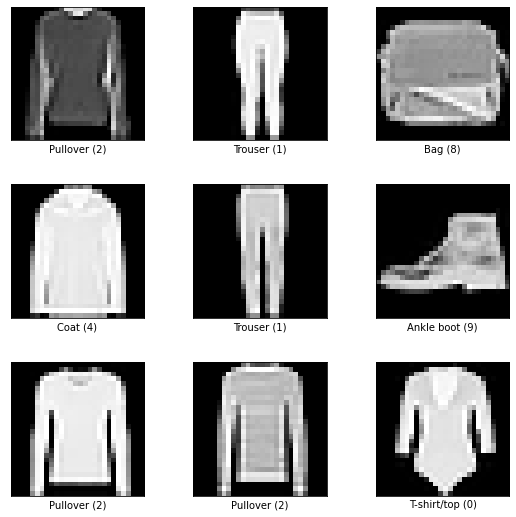

In [3]:
fig = tfds.show_examples(datasets["train"], datasets_info)

## Data preperation
For this simple example we extract the first 1000 images from the dataset for training the network, we extract the next 1000 images for a validation test set. The labels are converted to classes with one-hot encoding.

In [4]:
from tensorflow.keras.utils import to_categorical

train_data = datasets["train"].batch(1000)
train_data = iter(train_data)

# get first batch as training data
batch_1 = next(train_data)
X_train = batch_1["image"].numpy()
Y_train = to_categorical(batch_1["label"].numpy())

# get second batch as testing data
batch_2 = next(train_data)
X_test = batch_2["image"].numpy()
Y_test = to_categorical(batch_2["label"].numpy())

input_shape = datasets_info.features["image"].shape
num_classes = datasets_info.features["label"].num_classes

## Model fitting
The model is composed of several convolution layers. Each conv layer contains 32 convolution kernels and a `relu` activation function. The max pooling layers that follow convolution layers are used to reduce the dimension of the hidden layers so that when we pass the outputs to a fully connected dense layer the number of neurons is fewer. The dropout layer is used to reduce overfitting on the training set. A softmax activation is used to convert the network output to a probability for each class.

In [5]:
model = tfk.Sequential(
    [
        tfk.layers.Convolution2D(
            32, kernel_size=5, input_shape=input_shape, activation=tfk.activations.relu
        ),
        tfk.layers.MaxPooling2D(pool_size=2),
        tfk.layers.Convolution2D(
            32, kernel_size=4, activation=tfk.activations.relu, padding="same"
        ),
        tfk.layers.MaxPooling2D(pool_size=2),
        tfk.layers.Convolution2D(32, kernel_size=3, activation=tfk.activations.relu),
        tfk.layers.Flatten(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(num_classes),
        tfk.layers.Activation("softmax"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

The model is trained via the ADAM optimiser for 100 epochs.

In [6]:
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size=64,
    epochs=100,
    verbose=1,
)

Epoch 1/100
16/16 [==============================] - 1s 52ms/step - loss: 11.0994 - accuracy: 0.2300 - val_loss: 1.7835 - val_accuracy: 0.4470
Epoch 2/100
16/16 [==============================] - 1s 40ms/step - loss: 1.5810 - accuracy: 0.4690 - val_loss: 1.1647 - val_accuracy: 0.5710
Epoch 3/100
16/16 [==============================] - 1s 40ms/step - loss: 1.1094 - accuracy: 0.5990 - val_loss: 0.9348 - val_accuracy: 0.6590
Epoch 4/100
16/16 [==============================] - 1s 39ms/step - loss: 0.8786 - accuracy: 0.6810 - val_loss: 0.7860 - val_accuracy: 0.7340
Epoch 5/100
16/16 [==============================] - 1s 41ms/step - loss: 0.7583 - accuracy: 0.7200 - val_loss: 0.7140 - val_accuracy: 0.7540
Epoch 6/100
16/16 [==============================] - 1s 40ms/step - loss: 0.6591 - accuracy: 0.7500 - val_loss: 0.6625 - val_accuracy: 0.7630
Epoch 7/100
16/16 [==============================] - 1s 39ms/step - loss: 0.5634 - accuracy: 0.7860 - val_loss: 0.6441 - val_accuracy: 0.7570
Epoch

We can see that the performance of the network has converged well, and we would not expect any further performance gains with more training.
The performance of the test set is expectedly worse than the training set. It has converged to an accuracy >80%.

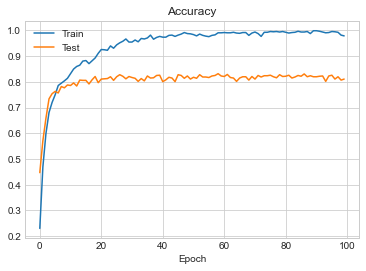

In [7]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Predictions
We can run some of the test set through the model to get some predictions. The model outputs a probability for each possible class. Alongside each image we display the class that was assigned the highest probability along and the associated value.

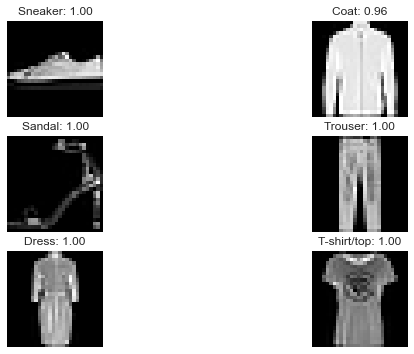

In [8]:
n_images = 6
test_images = X_test[np.random.randint(0, high=X_test.shape[0], size=n_images)]
predictions = model(test_images)

fig, ax = plt.subplots(ncols=2, nrows=int(np.ceil(n_images / 2)), figsize=(10, 6))

for i in range(n_images):
    ax[i // 2, i % 2].imshow(np.reshape(test_images[i], [28, 28]), cmap="gray")
    pred_name = datasets_info.features["label"].names[np.argmax(predictions.numpy()[i])]
    pred_conf = predictions.numpy()[i][np.argmax(predictions.numpy()[i])]
    ax[i // 2, i % 2].set_title(f"{pred_name}: {pred_conf:.2f}")
    ax[i // 2, i % 2].axis("off")

plt.show()

After making predictions on the whole test set, we can generate a confusion matrix to show which classes are more commonly confused by the model.

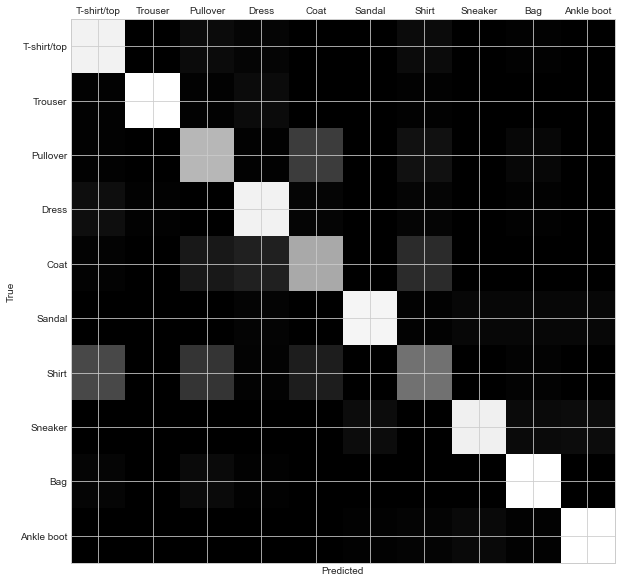

In [9]:
from sklearn.metrics import confusion_matrix

all_predictions = model(X_test)
all_pred_conf = np.max(all_predictions, axis=1)
pred_label = np.argmax(all_predictions, axis=1)
true_label = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(true_label, pred_label, normalize="true")

fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(conf_matrix, cmap='gray')
ax.matshow(conf_matrix, cmap="gray")
ax.set_xticks(np.arange(len(datasets_info.features["label"].names)))
ax.set_yticks(np.arange(len(datasets_info.features["label"].names)))
ax.set_xticklabels(datasets_info.features["label"].names)
ax.set_yticklabels(datasets_info.features["label"].names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The above matrix shows out of all items - pullovers, shirts and coats are the most confused. There is also some confusion on some sneakers and ankle boots. This all makes sense as those items are more similar.

The model is generally very confidence on its predictions:

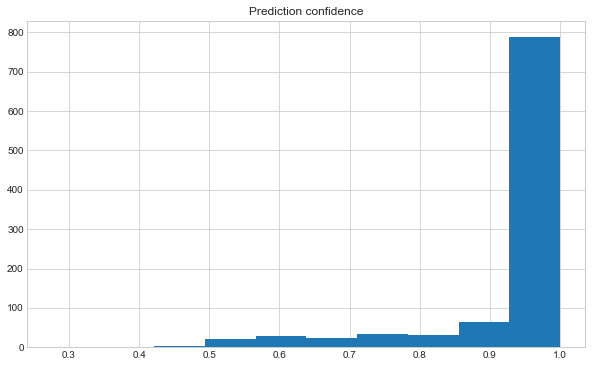

In [10]:
plt.subplots(figsize=(10, 6))
plt.hist(all_pred_conf)
plt.title("Prediction confidence")
plt.show()

We can plot some examples of the least confident predictions made by the model:

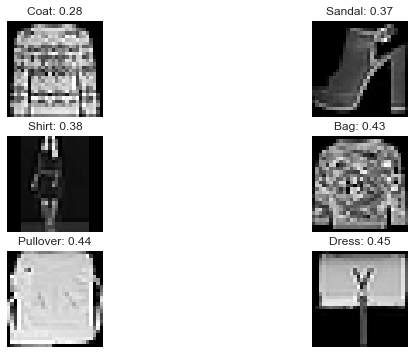

In [12]:
n_images = 6
idx = np.argsort(all_pred_conf)[:n_images]

fig, ax = plt.subplots(ncols=2, nrows=int(np.ceil(n_images / 2)), figsize=(10, 6))

for i, id in enumerate(idx):
    ax[i // 2, i % 2].imshow(np.reshape(X_test[id], [28, 28]), cmap="gray")
    pred_name = datasets_info.features["label"].names[
        np.argmax(all_predictions.numpy()[id])
    ]
    pred_conf = all_predictions.numpy()[id][np.argmax(all_predictions.numpy()[id])]
    ax[i // 2, i % 2].set_title(f"{pred_name}: {pred_conf:.2f}")
    ax[i // 2, i % 2].axis("off")

plt.show()